# Réseau de neurones

-- Courtenay Rebecca & Nguyen Duc Anh

## Table des matières

* [I. Importation des packages](#chapter1)
* [II. Implémentation en code python](#chapter2)
    * [1. Modèle de type perceptron multi-couches](#section_2_1)
    * [2. Représentations de taux d’erreur et de taux de réussite](#section_2_2)
    * [3. Représentations des erreurs](#section_2_3)
        * [3.1. Matrice de confusion](#section_2_2_2)
        * [3.2. Affichage des erreurs](#section_2_2_3)
* [III. Préparation des données](#chapter3)
    * [1. Fonctions de pré-traitement](#section_3_1)
        * [1.1. Normalisation des données](#section_3_1_1)
        * [1.2. Standardisation des données](#section_3_1_2)
        * [1.3. Seuillage des images](#section_3_1_3)
        * [1.4. Data augmentation](#section_3_1_4)
    * [2. Représentation des 25 premières images](#section_3_2)
    * [3. Préparation des nouveaux jeux de données](#section_3_3)
* [IV. Elaboration des expérimentations](#chapter4)
    * [1. Chargement des données du fichier mnist](#section_4_1)
    * [2. Sans pré-traitement (sauf normalisation) des données](#section_4_2)
        * [2.1. Expérimentation: algorithme optimisation SGD avec différents batch size](#section_4_2_1)
        * [2.2. Expérimentation: algorithme optimisation Adam, 2 couches cachées avec différents batch size](#section_4_2_2)
        * [2.3. Expérimentation: algorithme optimisation Adam, 3 couches cachées avec différents batch size](#section_4_2_3)
    * [3. Data augmentation](#section_4_4)   
        * [3.1. Expérimentation: algorithme optimisation Adam avec différents batch size](#section_4_4_1)
    * [4. Avec seuillage](#section_4_3)    
        * [4.1. Expérimentation: algorithme optimisation Adam avec différents batch size](#section_4_3_1)
    * [5. Avec standardisation des données](#section_5_4)   
        * [5.1. Expérimentation: algorithme optimisation Adam, 3 couches cachées avec différents batch size](#section_4_5_1)
    * [6. Meilleur modèle](#section_6_4)   
        * [6.1. Comparaison taux de réussite](#section_4_6_1)
        * [6.2. Meilleur modèle](#section_4_6_2)
            * [6.2.1. Meilleur modèle sans sur-apprentissage](#section_4_6_2_1)
* [V. Conclusion](#chapter5)

## I. Importation des packages <a class= "anchor" id="chapter1"></a>

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras
from keras.layers import Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator

___

## II. Implémentation en code python <a class= "anchor" id="chapter2"></a>

### 1. Modèle de type perceptron multi-couches <a class= "anchor" id="section_2_1"></a>

Création de la fonction python permettant de produire différents réseaux de neurones de type perceptron multicouches.

Pour la création du modèle, elle se fait couche par couche. Nous avons un modèle de type perceptron multi-couches, où le nombre de couches à faire est à entré en paramètre, avec :
- Dropout : fixé à 20% → une entrée sur 5 sera exclue de manière aléatoire dans chaque cycle de mise à jour ;
- Des couches cachées de 128 neurones (par défaut mais peut être modifié) avec des activations (ReLU par défaut, mais peut être modifié) ;
- Une couche de sortie de 10 neurones avec activation Softmax car en sortie nous avons un label et plusieurs classes.

Puis nous avons configuré la méthode d'entrainement de ce modèle en prenant en compte plusieurs critères :
- optimizer : algorithme d'optimisation utilisé (par défaut adam mais peut être modifié) ;
- loss : la fonction objective que l'on souhaite minimiser (ici sparse_categorical_crossentropy) ;
- metrics : la métrique considée pour évaluer les performances (ici accuracy).

Puis, nous pouvons entraîner le modèle en précisant la façon dont les données seront présentées lors de l'entrainement :
- epochs : un passage sur l'ensemble des données de la base d'entrainement (par défaut 20, mais peut être modifié) ;
- batch_size : définit le nombre d'exemples qui seront propagés à chaque itération pour calculer la mise à jour des poids (par défaut 128, mais peut être modifié).

Ensuite, nous ajustons le modèle : nous l'entraînons donc sur nos données train. Où :
- epochs : nombre de fois qu'il faut itérer sur les tableaux de données ;
- batch_size : nombre d'échantillons par mise à jour du gradient ;
- callbacks : objet qui peut effectuer des actions à différentes étapes de la formation qui a été crée par nous même avec callbacks.EarlyStopping :
    - monitor : quantité à surveiller (ici les pertes "loss") ;
    - mode : mode (ici "min") ;
    - patience : nombre d'époch sans amélioration après lesquelles l'entrainement sera arrêté (ici 4) ;
    - restore_best_weights : s'il faut tester les poids du modèle à partir de l'époch avec la meilleure valeur de la quantité surveillé (ici vrai) ;
    - verbose : mode de verbosité (ici 2 : une ligne de journal par époch) ;
    - validation_data : données qui aide à la validation (ici x_validate et y_validate).

Pour finir, nous avons cherché à valider notre modèle. En effet, nous regardons si le modèle est le mieux adapté au problème donné et aux données correspondantes. Pour cela, nous avons besoin des données de test et leurs étiquettes. Nous rentrons également le nombre d'exemples à propagés pour chaque itération.

In [3]:
def mlp_model(train_set, test_set, validate_set, optimizer_name='adam',
              nb_hidden_layer=3, nb_cellules=128, batch_size=128,
              learning_rate=0.001, epochs=20, activation_function="relu", do_data_augmentation=False):
    """
    :param do_data_augmentation : algorithm de data augmentation
    :param optimizer_name : algorithme d'optimisation utilisé (par défaut adam mais peut être modifié)
    :param batch_size : nombre d'échantillons par mise à jour du gradient
    :param train_set :
    :param test_set :
    :param validate_set :
    :param learning_rate :
    :param activation_function : type de fonction d'activation
    :param epochs : nombre de fois qu'il faut itérer sur les tableaux de données
    :param nb_hidden_layer : nombre de couches cachées
    :param nb_cellules : nombre de cellules par couche cachée
    """

    keras_model = keras.models.Sequential()
    keras_model.add(Dropout(0.2))
    for ix in range(nb_hidden_layer):
        keras_model.add(Dense(nb_cellules, activation=activation_function))
    # une couche de sortie de 10 neurones avec activation Softmax
    keras_model.add(Dense(10, activation='softmax'))

    x_train = train_set[0]
    y_train = train_set[1]
    x_test = test_set[0]
    y_test = test_set[1]
    x_validate = validate_set[0]
    y_validate = validate_set[1]

    #Compilation
    optimizer = None
    if optimizer_name == "sgd":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
    elif optimizer_name == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    keras_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    callback = [keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=4, restore_best_weights=True)]

    #Fit
    if do_data_augmentation:
        train_gen, validate_gen = data_augmentation(x_train, y_train, x_validate, y_validate)
        keras_model_fit = keras_model.fit(train_gen.x.reshape(len(train_gen.x), 784), train_gen.y, epochs=epochs, batch_size=batch_size, callbacks=callback, verbose=0, validation_data=(validate_gen.x.reshape(len(validate_gen.x), 784), validate_gen.y))
    else:
        keras_model_fit = keras_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=callback, verbose=0, validation_data=(x_validate, y_validate))

    #Summary
    #     model.summary()

    #Evaluate
    model_score = keras_model.evaluate(x_test, y_test, batch_size=batch_size)

    return keras_model, keras_model_fit, model_score


Ensuite, nous enregistrons tous les modèles que nous avons effectué dans model_path.

In [4]:
def save_model(my_model, my_model_name):
    save_dir = "./results/"
    model_path = save_dir + my_model_name
    my_model.save(model_path)
    print('Saved trained model at %s ' % model_path)

### 2. Représentations de taux d'erreur et taux de réussite <a class= "anchor" id="section_2_2"></a>

Grâce à l'historique de model.fit (voir Implémentation en code Python) nous pouvons récupérer plusieurs métriques qui sont stockées dans un dictionnaire :
- accuracy
- val_accuracy
- loss
- val_loss

De ce fait, cela inclut la perte (loss) et la précision (accuracy) ainsi que la perte et la précision de l'ensemble de données de validation. Et nous pouvons créer des graphiques à partir de celles-ci.

Nous avons créé un graphique de précision (accuracy) sur les ensembles de données d'entrainement et de validation.

Puis un graphique de perte (loss) sur les ensembles de données d'entrainement et de validation.

In [5]:
def plot_model_result(target_model_fit):
    plt.subplot(2, 1, 1)
    plt.plot(target_model_fit.history['accuracy'])
    plt.plot(target_model_fit.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')

    plt.subplot(2, 1, 2)
    plt.plot(target_model_fit.history['loss'])
    plt.plot(target_model_fit.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.tight_layout()

### 3. Représentations des erreurs <a class= "anchor" id="section_2_3"></a>

#### 3.1. Matrice de confusion <a class= "anchor" id="section_2_2_2"></a>

Nous mettons en place une matrice de confusion permettant de nous donner la différence entre la prédiction et la valeur que représente l'image.

Chaque ligne de la matrice représente les instances de la véritable classe alors que chaque colonne représente les instances de la classe de prédiction. 

Pour cela, nous récupérons d'abord le modèle prédictif ajusté grâce aux jeux de données test. 

Puis nous appliquons la fonction argmax de numpy qui renvoie l'index de l'axe le plus grand. Par exemple, ici, nous avons d'abord y_pred = [0 1 0 0 0 0 0 0 0], cela représente le 1. Avec argmax, Y_pred deviendra donc 1. Nous faisons cela pour les véritables valeurs et les prédictions. 

Ensuite, nous appliquons la fonction confusion_matrix qui évalue l'exactitude d'une classification.
Pour son affichage, nous prenons sa transposé pour tracer les données sous forme de matrice codée en couleur (nuance de bleu ici) avec des rectangles. 

In [6]:
def plot_confusion_matrix(model_to_plot, test_data):
    y_pred = model_to_plot.predict(test_data[0])
    y_pred_label = np.argmax(y_pred, 1)
    y_test_label = list(test_data[1])

    mat = confusion_matrix(y_test_label, y_pred_label)
    cmd = ConfusionMatrixDisplay(confusion_matrix=mat.T)
    fig, ax1 = plt.subplots(figsize=(8, 8))
    cmd.plot(cmap=plt.cm.Blues, ax=ax1)

    return y_pred_label, y_test_label

#### 3.2. Affichage des erreurs <a class= "anchor" id="section_2_2_3"></a>
Afficher des images que le modèle prédit incorrectement. 

Pour cela, nous récupèrons les index dans prédiction et dans le jeu de données test, où il y a une erreur entre la prédiction et la véritable valeur. 

Ainsi, nous affichons, une fois pour les 10 chiffres, l'image de la vraie valeur et sa prédiction. 
Pour cela, notre if vérifie bien que nous prenons une fois le même chiffre en s'aidant de son emplacement et qu'il y a bien des erreurs de prédictions (si ce n'est pas le cas, aucune erreur ne s'affiche). 

In [7]:
def display_errors(label_pred, label_test, data_test):
    #     label_test = np.argmax(label_test, 1)
    label_test = label_test.values
    errors = (label_pred - label_test != 0)
    Y_pred_errors_class = label_pred[errors]  # [1, 2, 3, 5, 9, ....]
    Y_test_errors_class = label_test[errors]  # [2, 2, 3, 5, 9, ....]

    X_test_errors = data_test[errors]
    n = 0
    nrows = 2
    ncols = 5
    fig, ax3 = plt.subplots(nrows, ncols, figsize=(10, 7))
    for row in range(nrows):
        for col in range(ncols):
            error_index = np.where(Y_test_errors_class == ncols * row + col)
            if error_index and len(error_index[0]) != 0:
                error_index = np.random.choice(error_index[0], size=1)
            else:
                continue
            ax3[row, col].imshow((X_test_errors[error_index]).reshape((28, 28)), cmap=plt.cm.binary)
            ax3[row, col].set_title("Predicted label :{}\nTrue label :{}".format(Y_pred_errors_class[error_index], Y_test_errors_class[error_index]))
            n += 1

---

## III. Préparation des données <a class= "anchor" id="chapter3"></a>

### 1. Fonctions de pré-traitement <a class= "anchor" id="section_3_1"></a>
Nous effectuons des pré-traitements sur les données d'entrée à travers différentes fonctions :

#### 1.1. Normalisation des données <a class= "anchor" id="section_3_1_1"></a>
Normaliser les données pour avoir des données entre 1 et -1.

In [8]:
def normalize(x):
    return x / 255

#### 1.2. Standardisation des données <a class= "anchor" id="section_3_1_2"></a>
Standardiser les données en supprimant la moyenne et en mettant à l'échelle la variance unitaire.

In [9]:
def standardize(x):
    mean_px = x.mean().astype(np.float32)
    std_px = x.std().astype(np.float32)
    x_scaled = (x - mean_px) / std_px
    return x_scaled

#### 1.3. Seuillage des images <a class= "anchor" id="section_3_1_3"></a>

Appliquer un seuillage manuelle sur une image en prenant compte de plusieurs paramètres :
- image à traiter ;
- valeur du seuil (0.5 par défaut) ;
- la couleur que prendra les objets une fois seuillé (ici 1) ;
- type de seuillage (ici TRESH_BINARY).

In [10]:
def img_preprocessing(x, threshold=0.5):
    # return cv.threshold(x, threshold, 1, cv.THRESH_BINARY)[1]
    return np.where(x >= threshold, 1.0, 0.0)

#### 1.4. Data augmentation <a class= "anchor" id="section_3_1_4"></a>

Pivoter aléatoirement nos images : 
- featurewise_center : définit la moyenne d'entrée sur 0 sur l'ensemble de données (ici non) ;
- samplewise_center : définit chaque moyenne d'échantillon sur 0 (ici non) ;
- featurewise_std_normalization : diviser les entrées par l'écart-type de l'ensemble de données (ici non) ;
- samplewise_std_normalization : diviser chaque entrée par sa norme (ici non) ;
- zca_whitening : appliquer le ZCA de Blanchinement (ici non) ;
- rotation_range : faire pivoter aléatoirement les images dans la plage (de 0° à 180°) (ici à 15°) ;
- zoom_range : agrandir l'image au hasard (ici de 0.01) ;
- width_shift_range : décaler aléatoirement les images horizontalement (ici de 0.1 (fraction de la largeur totale)) ;
- height_shift_range : décaler aléatoirement les images verticalement (ici de 0.1 (fraction de la largeur totale)) ;
- horizontal_flip : images retournées au hasard à l'horizontale (ici non) ; 
- vertical_flip : images retournées au hasard à la verticale (ici non). 

In [11]:
def data_augmentation(x_train, y_train, x_validate, y_validate):
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=15,
        zoom_range=0.01,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

    train_gen = datagen.flow(x_train.reshape(len(x_train), 28, 28, 1), y_train, batch_size=128)
    validate_gen = datagen.flow(x_validate.reshape(len(x_validate), 28, 28, 1), y_validate, batch_size=128)
    return train_gen, validate_gen

### 2. Représentation des 25 premières images <a class= "anchor" id="section_3_2"></a>

- prépration du jeu de données pour qu'il soit conforme : donne une nouvelle "shape" ;
- plt.subplot : création d'une figure avec 5x5 grilles de sous-parcelles ;
- plt.xticks : définir les emplacements des graduations de l'axe x ;
- plt.yticks : définir les emplacements des graduations de l'axe y ;
- plt.grid : si on veut afficher les grilles (ici non) ;
- plt.imshow : afficher les données sous forme d'image (2D).

In [12]:
def display_img(x, y):
    plt.figure(figsize=(8, 8))
    x = x.reshape(len(x), 28, 28, 1)
    for ixx in range(25):
        plt.subplot(5, 5, ixx + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x[ixx], cmap=plt.cm.binary)
        plt.title(y[ixx])

### 3. Préparation des nouveaux jeux de données <a class= "anchor" id="section_3_3"></a>

Appel du jeu de données mnist_all et création des jeux test, train et validate
- Partager données entre Y et X : 
    - Y : les données de la première colonne du jeu de données -> elles représentent les numéros qu'il faut avoir ;
    - X : les données -> pixels des images.
- train_test_split : divise nos jeux de données en sous-ensembles d'entraînement, de test et de validation
    - test_size : donner la proportion que nous voulons mettre dans d'abord test puis dans validate : 10% dans test, 20% dans validate et 70% dans train ;
    - stratify : divise l'ensemble de données en conservant les mêmes proportions d'exemples dans chaque classe que celles observées dans l'ensemble de données d'origine ;
    - On l'applique 2 fois pour séparer en 3 fois les jeux de données initiaux.
- plot : permettre l'affichage des chiffres (y) en général puis dans chaque jeux de données.

In [13]:
def load_and_split_data():
    data = pd.read_csv("mnist_all.csv")
    x = np.array(data.iloc[:, 1:])
    y = data.iloc[:, 0]

    x_train_validate, x_test, y_train_validate, y_test = train_test_split(x, y, test_size=0.1, random_state=0, stratify=y)
    x_train, x_validate, y_train, y_validate = train_test_split(x_train_validate, y_train_validate, test_size=0.2, random_state=0, stratify=y_train_validate)

    #plot for distribution sort descending
    all_label = y.value_counts().sort_index(ascending=False).plot(kind='barh', title="Label distribution")
    all_label.bar_label(all_label.containers[0])

    #plot label for train, test , validate
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    train_label_plot = y_train.value_counts().sort_index(ascending=False).plot(kind='barh', ax=axes[0], title="Train label distribution - 70%")
    train_label_plot.bar_label(train_label_plot.containers[0])
    test_label_plot = y_test.value_counts().sort_index(ascending=False).plot(kind='barh', ax=axes[1], title="Test label distribution - 10%")
    test_label_plot.bar_label(test_label_plot.containers[0])
    validate_label_plot = y_validate.value_counts().sort_index(ascending=False).plot(kind='barh', ax=axes[2], title="Validation label distribution - 20%")
    validate_label_plot.bar_label(validate_label_plot.containers[0])

    return [x_train, y_train], [x_test, y_test], [x_validate, y_validate]

Préparation final du jeu de donnée et affichage de la distribution des classes dans chaque ensemble de données.
- Normalisation de nos x (train, test, validate) ;
- Standardisation de nos x (optionnel) ;
- Appliquation d'un seuil sur une image (ici sur nos x_train, x_test, x_validate) (optionnel) ;
- Affichage des états de nos nouveaux jeux de données.

In [14]:
def data_preparation(train_origin, test_origin, validate_origin, process_img=False, standard_application=False):
    x_train = normalize(train_origin[0])
    x_test = normalize(test_origin[0])
    x_validate = normalize(validate_origin[0])

    if standard_application:
        x_train = standardize(x_train)
        x_test = standardize(x_test)
        x_validate = standardize(x_validate)

    if process_img:
        x_train = img_preprocessing(x_train)
        x_test = img_preprocessing(x_test)
        x_validate = img_preprocessing(x_validate)

    # y_train = keras.utils.to_categorical(train_origin[1], 10)
    # y_test = keras.utils.to_categorical(test_origin[1], 10)
    # y_validate = keras.utils.to_categorical(validate_origin[1], 10)

    y_train = train_origin[1]
    y_test = test_origin[1]
    y_validate = validate_origin[1]

    print('shape X train : ', x_train.shape)
    print('shape X test : ', x_test.shape)
    print('shape X validate : ', x_validate.shape)
    print('shape Y train : ', y_train.shape)
    print('shape Y test : ', y_test.shape)
    print('shape Y validate : ', y_validate.shape)

    return [x_train, y_train], [x_test, y_test], [x_validate, y_validate]

---

## IV. Elaboration des expérimentations <a class= "anchor" id="chapter4"></a>

### 1. Chargement des données du fichier mnist <a class= "anchor" id="section_4_1"></a>

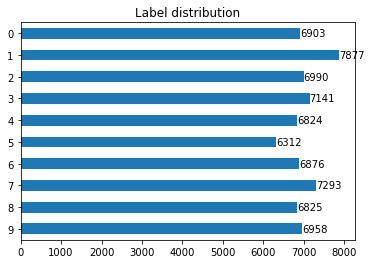

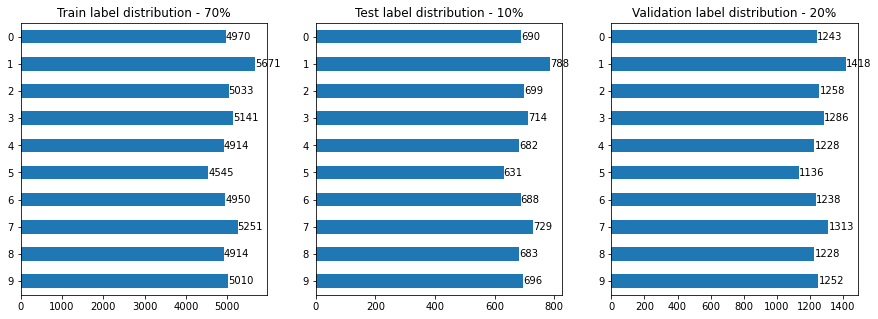

In [15]:
train_org, test_org, validate_org = load_and_split_data()
all_scores = {}
all_models = {}
all_models_fit = {}

Nous remarquons qu'il y a une bonne répartition des images pour chaque chiffres.

### 2. Sans pré-traitement (sauf normalisation) des données <a class= "anchor" id="section_4_2"></a>

In [16]:
train, test, validate = data_preparation(train_org, test_org, validate_org, process_img=False, standard_application=False)

shape X train :  (50399, 784)
shape X test :  (7000, 784)
shape X validate :  (12600, 784)
shape Y train :  (50399,)
shape Y test :  (7000,)
shape Y validate :  (12600,)


In [17]:
display_img(train[0], train[1].values)

#### 2.1. Expérimentation : algorithme optimisation SGD avec différents batch size <a class= "anchor" id="section_4_2_1"></a>
Description de l'expérimentation :
* nombre de couches cachées: **3**
* nombre de cellule: **128**
* batch size: **[32, 86, 200, 450]**
* optimizer: **SGD**
* learning rate: **0.001**
* epochs: **30**
* process image method: **None**
* activation function: **relu**

16/16 [==============================] - 0s 6ms/step - loss: 0.2566 - accuracy: 0.9270


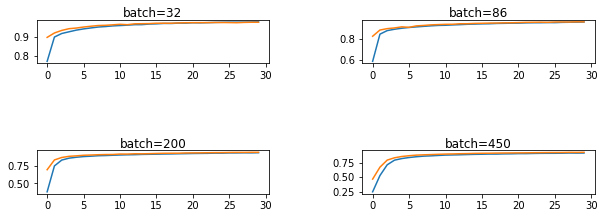

In [18]:
batch_sizes = [32, 86, 200, 450]
plt.figure(figsize=(10, 8)).subplots_adjust(hspace=2, wspace=0.4)
for i in range(len(batch_sizes)):
    model, model_fit, score = mlp_model(train_set=train,
                                        test_set=test,
                                        validate_set=validate,
                                        optimizer_name="sgd",
                                        nb_hidden_layer=3,
                                        nb_cellules=128,
                                        batch_size=batch_sizes[i],
                                        learning_rate=0.001,
                                        epochs=30,
                                        activation_function="relu")

    plot_no = 420 + (i + 1)
    plt.subplot(plot_no)
    plt.plot(model_fit.history['accuracy'], label='train')
    plt.plot(model_fit.history['val_accuracy'], label='validate')
    plt.title('batch=' + str(batch_sizes[i]), pad=-40)

    all_scores["model_sgd_" + str(batch_sizes[i])] = score
    all_models["model_sgd_" + str(batch_sizes[i])] = model
    all_models_fit["model_sgd_" + str(batch_sizes[i])] = model_fit

Pour ces modèles, nous remarquons qu'il est préférable de prendre un batch petit lorsque nous utilisons comme algortihme d'optimisation SGD qui est l'algorithme du gradient stochastique. En effet le temps d'exécution est plus long et le taux de réussite devient moins important. 

Cela est sûrement dû au fait que le calcul du gradient stochastique se concentre sur différents échantillons de l'ensemble de données global à chaque itération et donc plus le batch augmente plus le temps de calcul à chaque itération devient coûteux en temps et en ressources. 
De plus, les grandes tailles de lot ne permettent pas au modèle de voyager assez loin pour atteindre les meilleures soluions pour le même nombre d'époch d'entraînement. D'où le fait qu'il est mieux de prendre un batch size assez petit. 

Il faudrait augmenter le taux d'apprentissage ou le nombre d'epoch afin que le modèle puisse trouver des meilleures solutions.

#### 2.2. Expérimentation : algorithme optimisation Adam, 2 couches cachées avec différents batch size <a class= "anchor" id="section_4_2_2"></a>
Description de l'expérimentation :
* nombre de couches cachées: **2**
* nombre de cellule: **128**
* batch size: **[32, 86, 200, 450]**
* optimizer: **Adam**
* learning rate: **0.001**
* epochs: **30**
* process image method: **None**
* activation function: **relu**

16/16 [==============================] - 0s 4ms/step - loss: 0.0738 - accuracy: 0.9797


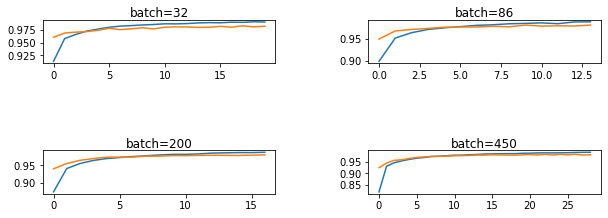

In [19]:
batch_sizes = [32, 86, 200, 450]
plt.figure(figsize=(10, 8)).subplots_adjust(hspace=2, wspace=0.4)

for i in range(len(batch_sizes)):
    model, model_fit, score = mlp_model(train_set=train,
                                        test_set=test,
                                        validate_set=validate,
                                        optimizer_name="adam",
                                        nb_hidden_layer=2,
                                        nb_cellules=128,
                                        batch_size=batch_sizes[i],
                                        learning_rate=0.001,
                                        epochs=30,
                                        activation_function="relu")
    plot_no = 420 + (i + 1)
    plt.subplot(plot_no)

    plt.plot(model_fit.history['accuracy'], label='train')
    plt.plot(model_fit.history['val_accuracy'], label='validate')
    plt.title('batch=' + str(batch_sizes[i]), pad=-40)

    all_scores["model_adam_2couches" + str(batch_sizes[i])] = score
    all_models["model_adam_2couches" + str(batch_sizes[i])] = model
    all_models_fit["model_adam_2couches" + str(batch_sizes[i])] = model_fit

Ici, nous remarquons que plus le batch augmente, plus le temps d'éxecution augmente ainsi que le taux de réussite.

L'algorithme Adam est plus efficace que SGD pour travailler avec beaucoup de données (comme ici). Il prend en considération la moyenne pondérée exponentielle des gradients et a une insensibilité à l'initialisation du poids et au choix du taux initial d'apprentissage. Il trouve donc des solutions avec des poids beaucoup plus importants.

#### 2.3. Expérimentation : algorithme optimisation Adam, 3 couches cachées avec différents batch size <a class= "anchor" id="section_4_2_3"></a>
Description de l'expérimentation :
* nombre de couches cachées: **3**
* nombre de cellule: **128**
* batch size: **[32, 86, 200, 450]**
* optimizer: **Adam**
* learning rate: **0.001**
* epochs: **30**
* process image method: **None**
* activation function: **relu**

16/16 [==============================] - 0s 5ms/step - loss: 0.0687 - accuracy: 0.9823


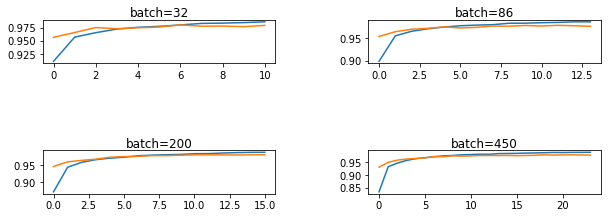

In [20]:
batch_sizes = [32, 86, 200, 450]
plt.figure(figsize=(10, 8)).subplots_adjust(hspace=2, wspace=0.4)

for i in range(len(batch_sizes)):
    model, model_fit, score = mlp_model(train_set=train,
                                        test_set=test,
                                        validate_set=validate,
                                        optimizer_name="adam",
                                        nb_hidden_layer=3,
                                        nb_cellules=128,
                                        batch_size=batch_sizes[i],
                                        learning_rate=0.001,
                                        epochs=30,
                                        activation_function="relu")
    plot_no = 420 + (i + 1)
    plt.subplot(plot_no)

    plt.plot(model_fit.history['accuracy'], label='train')
    plt.plot(model_fit.history['val_accuracy'], label='validate')
    plt.title('batch=' + str(batch_sizes[i]), pad=-40)

    all_scores["model_adam_3couches" + str(batch_sizes[i])] = score
    all_models["model_adam_3couches" + str(batch_sizes[i])] = model
    all_models_fit["model_adam_3couches" + str(batch_sizes[i])] = model_fit

Comparées aux expérimentations faites juste au-dessus, nous ne remarquons pas une grande différence. En effet, le nombre de couches cachées (ici 3 e 2 plus haut) n'a pas d'impact important sur le choix de notre modèle. 

### 3. Data augmentation <a class= "anchor" id="section_4_4"></a>

#### 3.1. Expérimentation : algorithme optimisation Adam avec différents batch size <a class= "anchor" id="section_4_4_1"></a>
Description de l'expérimentation :
* nombre de couches cachées: **1**
* nombre de cellule: **784**
* batch size: **32**
* optimizer: **Adam**
* learning rate: **0.001**
* epochs: **30**
* process image method: **None**
* activation function: **relu**

16/16 [==============================] - 0s 8ms/step - loss: 0.0650 - accuracy: 0.9826


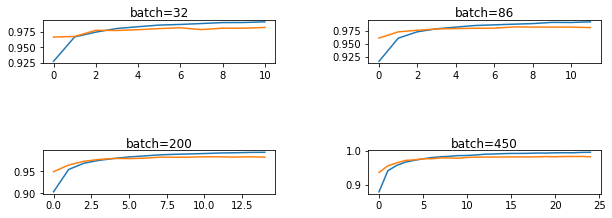

In [21]:
batch_sizes = [32, 86, 200, 450]
plt.figure(figsize=(10, 8)).subplots_adjust(hspace=2, wspace=0.4)

for i in range(len(batch_sizes)):
    model, model_fit, score = mlp_model(train_set=train,
                                        test_set=test,
                                        validate_set=validate,
                                        optimizer_name="adam",
                                        nb_hidden_layer=1,
                                        nb_cellules=784,
                                        batch_size=batch_sizes[i],
                                        learning_rate=0.001,
                                        epochs=30,
                                        activation_function="relu",
                                        do_data_augmentation=True)
    plot_no = 420 + (i + 1)
    plt.subplot(plot_no)

    plt.plot(model_fit.history['accuracy'], label='train')
    plt.plot(model_fit.history['val_accuracy'], label='validate')
    plt.title('batch=' + str(batch_sizes[i]), pad=-40)

    all_scores["model_data_aug" + str(batch_sizes[i])] = score
    all_models["model_data_aug" + str(batch_sizes[i])] = model
    all_models_fit["model_data_aug" + str(batch_sizes[i])] = model_fit

Nous avons également un faible signe de sur-apprentissage avec ce pré-traitement des données quelque soit le batch. Mais le taux de réussite est le plus haut que nous ayons pu avoir.

### 4. Avec seuillage <a class= "anchor" id="section_4_3"></a>

In [22]:
train, test, validate = data_preparation(train_org, test_org, validate_org, process_img=True)

shape X train :  (50399, 784)
shape X test :  (7000, 784)
shape X validate :  (12600, 784)
shape Y train :  (50399,)
shape Y test :  (7000,)
shape Y validate :  (12600,)


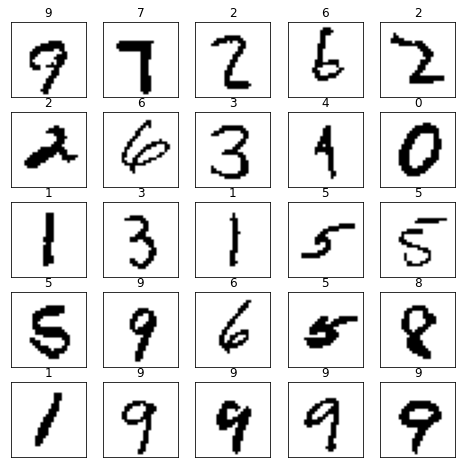

In [23]:
display_img(train[0], train[1].values)

#### 4.1. Expérimentation : algorithme optimisation Adam avec différents batch size <a class= "anchor" id="section_4_3_1"></a>
Description de l'expérimentation :
* nombre de couches cachées: **3**
* nombre de cellule: **128**
* batch size: **32**
* optimizer: **Adam**
* learning rate: **0.001**
* epochs: **30**
* process image method: **[binary threshold](https://docs.opencv.org/3.4.0/d7/d4d/tutorial_py_thresholding.html)**
* activation function: **relu**

In [24]:
batch_sizes = [32, 86, 200, 450]
plt.figure(figsize=(10, 8)).subplots_adjust(hspace=2, wspace=0.4)

for i in range(len(batch_sizes)):
    model, model_fit, score = mlp_model(train_set=train,
                                        test_set=test,
                                        validate_set=validate,
                                        optimizer_name="adam",
                                        nb_hidden_layer=3,
                                        nb_cellules=128,
                                        batch_size=batch_sizes[i],
                                        learning_rate=0.001,
                                        epochs=30,
                                        activation_function="relu")
    plot_no = 420 + (i + 1)
    plt.subplot(plot_no)

    plt.plot(model_fit.history['accuracy'], label='train')
    plt.plot(model_fit.history['val_accuracy'], label='validate')
    plt.title('batch=' + str(batch_sizes[i]), pad=-40)

    all_scores["model_imgprc" + str(batch_sizes[i])] = score
    all_models["model_imgprc" + str(batch_sizes[i])] = model
    all_models_fit["model_imgprc" + str(batch_sizes[i])] = model_fit

16/16 [==============================] - 0s 4ms/step - loss: 0.0946 - accuracy: 0.9757


On remarque qu'avec le seuillage que nous avons appliqué (de 0.5), il y a des risques de sur-apprentissage lorsque la taille du batch est petite. 

### 5. Avec standardisation des données <a class= "anchor" id="section_4_5"></a>

In [25]:
train, test, validate = data_preparation(train_org, test_org, validate_org, process_img=False, standard_application=True)

shape X train :  (50399, 784)
shape X test :  (7000, 784)
shape X validate :  (12600, 784)
shape Y train :  (50399,)
shape Y test :  (7000,)
shape Y validate :  (12600,)


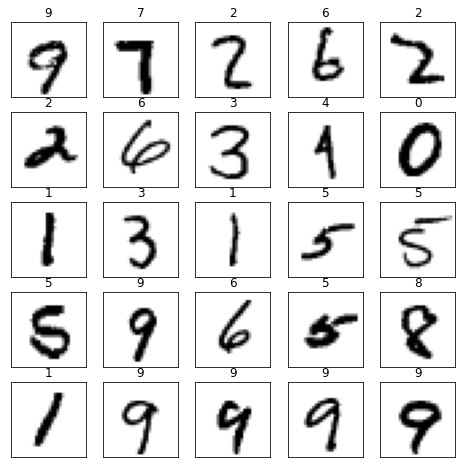

In [26]:
display_img(train[0], train[1].values)

#### 5.1. Expérimentation : algorithme optimisation Adam, 3 couches cachées avec différents batch size <a class= "anchor" id="section_4_5_1"></a>
Description de l'expérimentation
* nombre de couches cachées : **3**
* nombre de cellule: **128**
* batch size: **[32, 86, 200, 450]**
* optimizer: **Adam**
* learning rate: **0.001**
* epochs: **30**
* process image method: **None**
* activation function: **sigmoid**

In [27]:
batch_sizes = [32, 86, 200, 450]
plt.figure(figsize=(10, 8)).subplots_adjust(hspace=2, wspace=0.4)

for i in range(len(batch_sizes)):
    model, model_fit, score = mlp_model(train_set=train,
                                        test_set=test,
                                        validate_set=validate,
                                        optimizer_name="adam",
                                        nb_hidden_layer=3,
                                        nb_cellules=128,
                                        batch_size=batch_sizes[i],
                                        learning_rate=0.001,
                                        epochs=30,
                                        activation_function="sigmoid")
    plot_no = 420 + (i + 1)
    plt.subplot(plot_no)

    plt.plot(model_fit.history['accuracy'], label='train')
    plt.plot(model_fit.history['val_accuracy'], label='validate')
    plt.title('batch=' + str(batch_sizes[i]), pad=-40)

    all_scores["model_norm_" + str(batch_sizes[i])] = score
    all_models["model_norm_" + str(batch_sizes[i])] = model
    all_models_fit["model_norm_" + str(batch_sizes[i])] = model_fit

16/16 [==============================] - 0s 4ms/step - loss: 0.0823 - accuracy: 0.9766


Lorsque nous standardisons les données, nous avons à peu près la même interprétation des graphiques que lorsque nous ne le faisons pas (voir 2.2). 

### 6. Meilleur modèle <a class= "anchor" id="section_4_6"></a>

#### 6.1. Comparaison taux de réussite <a class= "anchor" id="section_4_6_1"></a>

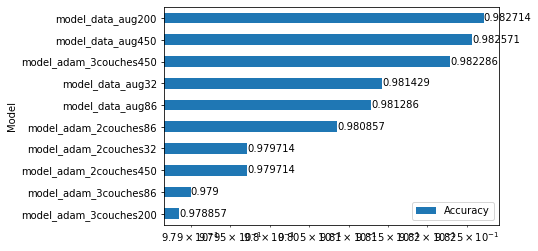

In [28]:
loss = [z[0] for z in all_scores.values()]
acc = [z[1] for z in all_scores.values()]
models = list(all_scores.keys())
scores_df = pd.DataFrame({'Model': models, 'Accuracy': acc, 'Loss': loss})
scores_df = scores_df.sort_values(by=['Accuracy'], ascending=True)
ax = scores_df[-10:].plot.barh(x='Model', y='Accuracy')
ax.set_xscale("log")
ax.bar_label(ax.containers[0])
plt.show()

In [29]:
ax2 = scores_df[-10:].plot.barh(x='Model', y='Loss')
ax2.set_xscale("log")
ax2.bar_label(ax2.containers[0])
plt.show()

#### 6.2. Meilleur modèle <a class= "anchor" id="section_4_6_2"></a>

In [30]:
scores_df = scores_df.sort_values(by=['Accuracy'], ascending=False)
model_name = scores_df.iloc[0]["Model"]
model = all_models[model_name]
model_fit = all_models_fit[model_name]
print("Le meilleur modèle est : ", model_name)

Le meilleur modèle est :  model_data_aug200


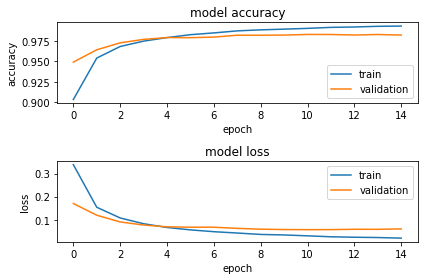

In [31]:
plot_model_result(model_fit)

Nous constatons un léger sur-apprentissage avec ce modèle. 

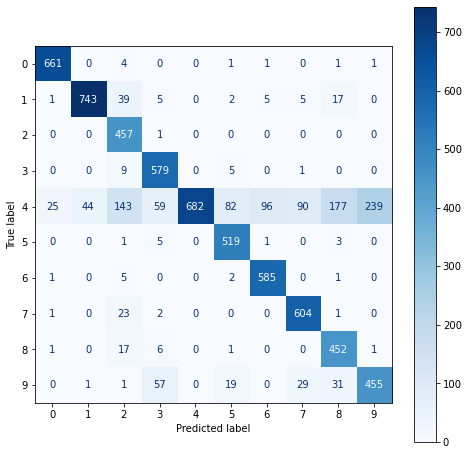

In [32]:
Y_pred, Y_test = plot_confusion_matrix(model, test)

Nous observons que la majorité des erreurs proviennent du 4. En effet, tous les chiffres sont souvent prédits comme étant le 4 (prédit un 8 243 fois alors que c'est un 4). Et celui-ci n'a jamais été prédit pour une autre valeur que lui-même.

De plus, même si le taux de réussite est le plus fort, nous remarquons qu'il y a de nombreuses erreurs.

In [33]:
display_errors(Y_pred, test[1], test[0])

Comme dit juste avant, le 4 est souvent prédit à tort. Il est difficile de comprendre réellement pourquoi lorsque nous regardons les images mal prédites.

Cependant, cette erreur de prédiction pour le chiffre 4 est sûrement dû à notre pré-traitement des images. Notre degré de pivot de l'image et l'agrandissemebt de celle-ci amènent à une reconnaissance (souvent à tord) du chiffre 4. 

#### 6.2.1. Meilleur modèle sans sur-apprentissage <a class= "anchor" id="section_4_6_2_1"></a>

Nous allons présenter le premier meilleur modèle qui ne montre aucun signe de sur-apprentissage. 

In [34]:
model_name = scores_df.iloc[9]["Model"]
model = all_models[model_name]
model_fit = all_models_fit[model_name]
print("Le meilleure modèle sans signe de sur-apprentissage : ", model_name)

Le meilleure modèle sans signe de sur-apprentissage :  model_adam_3couches200


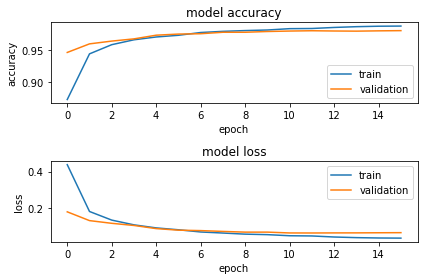

In [35]:
plot_model_result(model_fit)

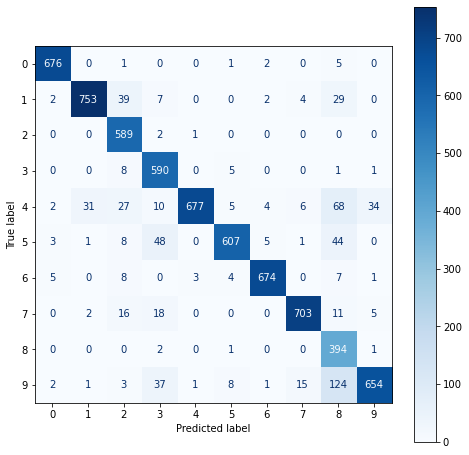

In [36]:
Y_pred, Y_test = plot_confusion_matrix(model, test)

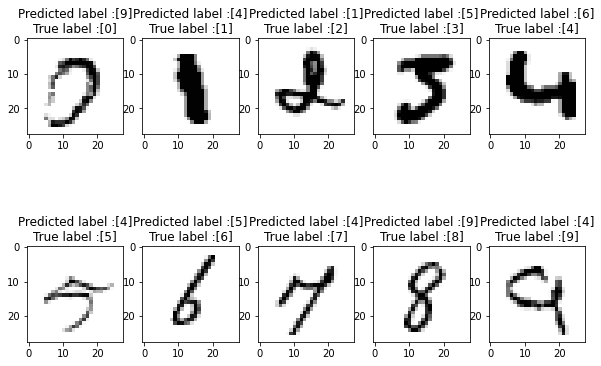

In [37]:
display_errors(Y_pred, test[1], test[0])

Contrairement à l'autre modèle, il n'a pas ce problème de prédire majoritairement le chiffre 4, ce qui confirme notre hypothèse concernant notre transformation des données qui prédit partout le chiffre 4. 

Nous constatons tout de même que le chiffre 4 est une nouvelle fois prédit à tord, le plus souvent. Notamment, il y a un problème de différenciation entre le chiffre 4 et 9. 

De plus, il y a souvent une mauvaise prédiction donnée pour le chiffre 1. La plupart du temps, le modèle prédit un 1 mais aussi un 2, un 3 ou un 8. 

## V. Conclusion <a class= "anchor" id="chapter5"></a>

Nous obtenons un très bon taux de précision lorsque nous effectuons un pré-traitement des données. 

Cependant, on remarque qu'il y a souvent des mauvaises prédictions pour le chiffre 4 et 1. Pour améliorer encore plus nos modèles, il faudrait faire un pré-traitement des données qui faciliterai la compréhension de ces deux chiffres, sans pour autant changer l'analyse des autres chiffres.

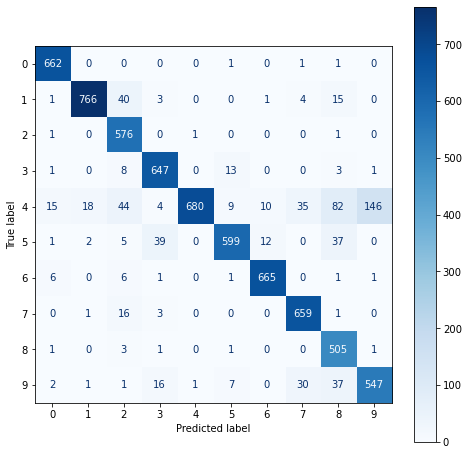

In [38]:
model_name = scores_df.iloc[8]["Model"]
model = all_models[model_name]
model_fit = all_models_fit[model_name]
Y_pred, Y_test = plot_confusion_matrix(model, test)